# Figures

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import os
from munkres import Munkres
import numpy.linalg as LA

In [2]:
%matplotlib inline

In [3]:
DATA_DIR = "/home/azouaoui/CH4/HySUPP/data"
LOGS_DIR = os.path.join(DATA_DIR, "logs")
data_path = os.path.join(DATA_DIR, "Sim1.mat")

In [4]:
data = sio.loadmat(data_path)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'E', 'A', 'H', 'W', 'p', 'L', 'D', 'M', 'index'])

In [5]:
A_GT = data["A"]
H = int(data["H"])
W = int(data["W"])
p, N = A_GT.shape

In [6]:
A_GT_img = A_GT.reshape(p, H, W)

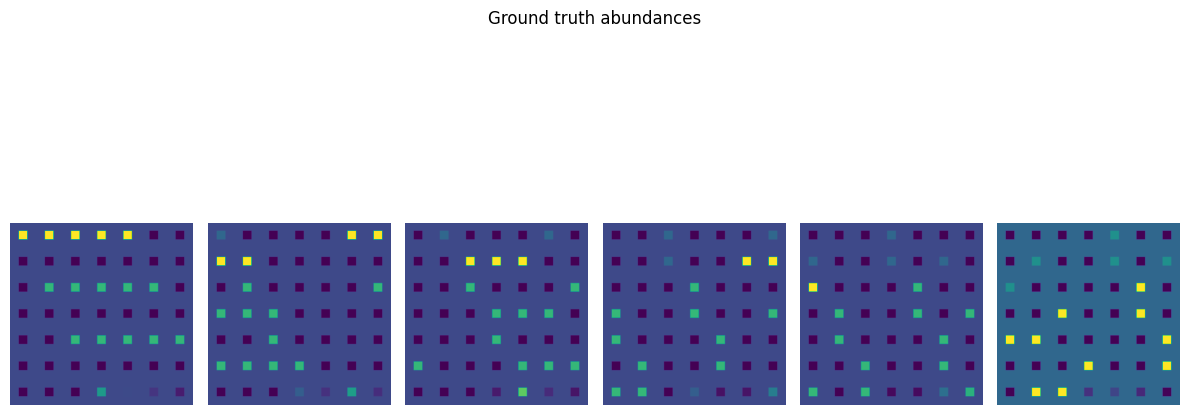

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=p, figsize=(12, 6))

for pp in range(p):
    ax[pp].imshow(A_GT_img[pp])
    ax[pp].axis("off")
fig.suptitle("Ground truth abundances");
plt.tight_layout()

In [12]:
A_FCLS_20 = sio.loadmat(os.path.join(LOGS_DIR, "324/artifacts/Estimate/estimates.mat"))["A"]
A_FCLS_20.shape

(6, 105, 105)

In [27]:
A_UnDIP_20 = sio.loadmat(os.path.join(LOGS_DIR, "333/artifacts/Estimate/estimates.mat"))["A"]
A_UnDIP_20.shape

(6, 105, 105)

In [29]:
A_SLIC_20 = sio.loadmat(os.path.join(LOGS_DIR, "340/artifacts/Estimate/estimates.mat"))["A"][:6]
A_SLIC_20.shape

(6, 105, 105)

In [30]:
A_SUnCNN_20 = sio.loadmat(os.path.join(LOGS_DIR, "338/artifacts/Estimate/estimates.mat"))["A"][:6]
A_SUnCNN_20.shape

(6, 105, 105)

In [31]:
A_SUnSAL_20 = sio.loadmat(os.path.join(LOGS_DIR, "347/artifacts/Estimate/estimates.mat"))["A"][:6]
A_SUnSAL_20.shape

(6, 105, 105)

In [32]:
A_CNNAEU_20 = sio.loadmat(os.path.join(LOGS_DIR, "349/artifacts/Estimate/estimates.mat"))["A"][:6]
A_CNNAEU_20.shape

(6, 105, 105)

In [35]:
A_MiSiCNet_20 = sio.loadmat(os.path.join(LOGS_DIR, "357/artifacts/Estimate/estimates.mat"))["A"][:6]
A_MiSiCNet_20.shape

(6, 105, 105)

In [34]:
A_S2WSU_20 = sio.loadmat(os.path.join(LOGS_DIR, "355/artifacts/Estimate/estimates.mat"))["A"][:6]
A_S2WSU_20.shape

(6, 105, 105)

In [36]:
A_EDAA_20 = sio.loadmat(os.path.join(LOGS_DIR, "362/artifacts/Estimate/estimates.mat"))["A"][:6]
A_EDAA_20.shape

(6, 105, 105)

In [37]:
A_NMFQMV_20 = sio.loadmat(os.path.join(LOGS_DIR, "363/artifacts/Estimate/estimates.mat"))["A"][:6]
A_NMFQMV_20.shape

(6, 105, 105)

## Aligner

In [13]:
class BaseMetric:
    def __init__(self):
        self.name = self.__class__.__name__

    @staticmethod
    def _check_input(X, Xref):
        assert X.shape == Xref.shape
        assert type(X) == type(Xref)
        return X, Xref

    def __call__(self, X, Xref):
        raise NotImplementedError

    def __repr__(self):
        return f"{self.name}"


class MeanSquareError(BaseMetric):
    def __init__(self):
        super().__init__()

    def __call__(self, E, Eref):
        E, Eref = self._check_input(E, Eref)

        normE = LA.norm(E, axis=0, keepdims=True)
        normEref = LA.norm(Eref, axis=0, keepdims=True)

        return np.sqrt(normE.T**2 + normEref**2 - 2 * (E.T @ Eref))

In [14]:
class BaseAbundancesAligner:
    def __init__(self, Aref, criterion):
        self.Aref = Aref
        self.criterion = criterion
        self.P = None
        self.dists = None

    def fit(self, A):
        raise NotImplementedError

    def transform(self, A):
        assert self.P is not None, "Must be fitted first"
        assert A.shape[0] == self.P.shape[0]
        assert A.shape[0] == self.P.shape[1]

        return self.P @ A

    def transform_endmembers(self, E):
        assert self.P is not None, "Must be fitted first"
        assert E.shape[1] == self.P.shape[0]
        assert E.shape[1] == self.P.shape[1]

        return E @ self.P.T

    def fit_transform(self, A):

        self.fit(A)
        res = self.transform(A)
        return res

    def __repr__(self):
        msg = f"{self.__class__.__name__}_crit{self.criterion}"
        return msg


class MunkresAbundancesAligner(BaseAbundancesAligner):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def fit(self, A):

        # Computing distance matrix
        self.dists = self.criterion(A.T, self.Aref.T)

        # Initialization
        p = A.shape[0]
        P = np.zeros((p, p))

        m = Munkres()
        indices = m.compute(self.dists)
        for row, col in indices:
            P[row, col] = 1.0

        self.P = P.T

In [17]:
MSE = MeanSquareError()

In [18]:
Aligner = MunkresAbundancesAligner(Aref=A_GT, criterion=MSE)

In [39]:
def align(A):
    return Aligner.fit_transform(A.reshape(p, N)).reshape(p, H, W)

In [56]:
A_FCLS = align(A_FCLS_20)
A_UnDIP = align(A_UnDIP_20)

#A_SUnSAL = align(A_SUnSAL_20)
#A_S2WSU = align(A_S2WSU_20)
#A_MUA = align(A_SLIC_20)
#A_SUnCNN = align(A_SUnCNN_20)

A_SUnSAL = A_SUnSAL_20
A_S2WSU = A_S2WSU_20
A_MUA = A_SLIC_20
A_SUnCNN = A_SUnCNN_20



A_CNNAEU = align(A_CNNAEU_20)
A_MiSiCNet = align(A_MiSiCNet_20)
A_NMFQMV = align(A_NMFQMV_20)
A_EDAA = align(A_EDAA_20)

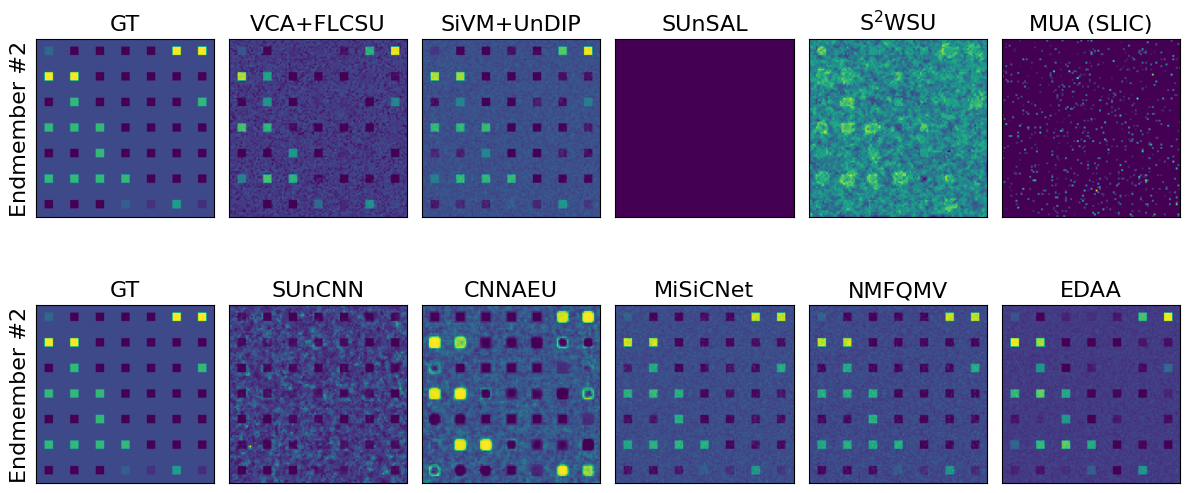

In [66]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(12, 6))

mappable = ax[0, 0].imshow(A_GT_img[1])
ax[0, 0].set_xticks([]);
ax[0, 0].set_yticks([]);
ax[0, 0].set_ylabel(f"Endmember #2", fontsize=16);
ax[0, 0].set_title("GT", fontsize=16);

ax[1, 0].imshow(A_GT_img[1])
ax[1, 0].set_xticks([]);
ax[1, 0].set_yticks([]);
ax[1, 0].set_ylabel(f"Endmember #2", fontsize=16);
ax[1, 0].set_title("GT", fontsize=16);


ax[0, 1].imshow(A_FCLS[1])
ax[0, 1].set_xticks([]);
ax[0, 1].set_yticks([]);
ax[0, 1].set_title("VCA+FLCSU", fontsize=16);

ax[0, 2].imshow(A_UnDIP[1])
ax[0, 2].set_xticks([]);
ax[0, 2].set_yticks([]);
ax[0, 2].set_title("SiVM+UnDIP", fontsize=16);

ax[0, 3].imshow(A_SUnSAL[1])
ax[0, 3].set_xticks([]);
ax[0, 3].set_yticks([]);
ax[0, 3].set_title("SUnSAL", fontsize=16);

ax[0, 4].imshow(A_S2WSU[1])
ax[0, 4].set_xticks([]);
ax[0, 4].set_yticks([]);
ax[0, 4].set_title("S$^2$WSU", fontsize=16);

ax[0, 5].imshow(A_MUA[1])
ax[0, 5].set_xticks([]);
ax[0, 5].set_yticks([]);
ax[0, 5].set_title("MUA (SLIC)", fontsize=16);


ax[1, 1].imshow(A_SUnCNN[1])
ax[1, 1].set_xticks([]);
ax[1, 1].set_yticks([]);
ax[1, 1].set_title("SUnCNN", fontsize=16);

ax[1, 2].imshow(A_CNNAEU[1])
ax[1, 2].set_xticks([]);
ax[1, 2].set_yticks([]);
ax[1, 2].set_title("CNNAEU", fontsize=16);

ax[1, 3].imshow(A_MiSiCNet[1])
ax[1, 3].set_xticks([]);
ax[1, 3].set_yticks([]);
ax[1, 3].set_title("MiSiCNet", fontsize=16);

ax[1, 4].imshow(A_NMFQMV[1])
ax[1, 4].set_xticks([]);
ax[1, 4].set_yticks([]);
ax[1, 4].set_title("NMFQMV", fontsize=16);

ax[1, 5].imshow(A_EDAA[1])
ax[1, 5].set_xticks([]);
ax[1, 5].set_yticks([]);
ax[1, 5].set_title("EDAA", fontsize=16);


#plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9)
#cax = plt.axes([0.92, 0.1, 0.02, 0.8])
#fig.colorbar(mappable, cax=cax);

plt.tight_layout()

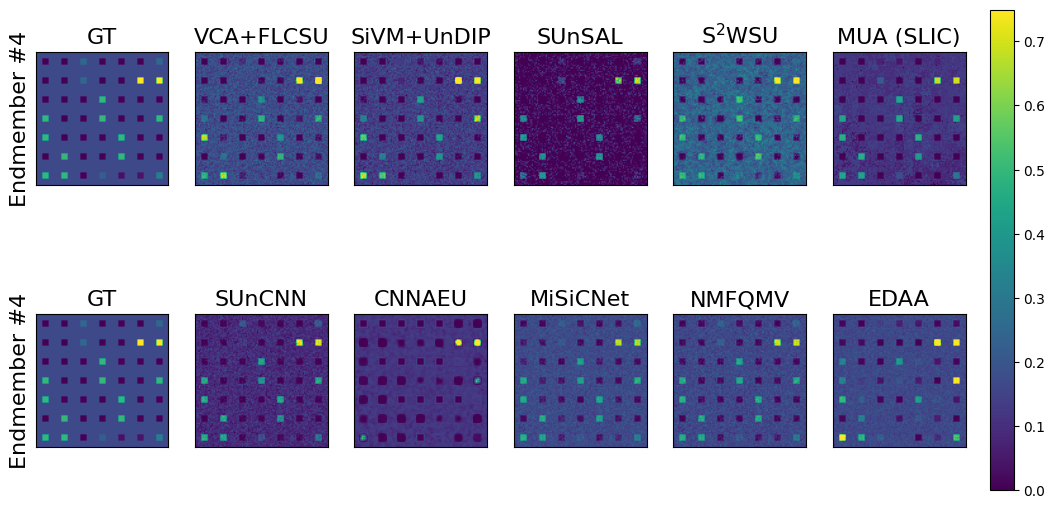

In [71]:
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(12, 6))

mappable = ax[0, 0].imshow(A_GT_img[3], vmin=A_GT_img[3].min(), vmax=A_GT_img[3].max())
ax[0, 0].set_xticks([]);
ax[0, 0].set_yticks([]);
ax[0, 0].set_ylabel(f"Endmember #4", fontsize=16);
ax[0, 0].set_title("GT", fontsize=16);

ax[1, 0].imshow(A_GT_img[3], vmin=A_GT_img[3].min(), vmax=A_GT_img[3].max())
ax[1, 0].set_xticks([]);
ax[1, 0].set_yticks([]);
ax[1, 0].set_ylabel(f"Endmember #4", fontsize=16);
ax[1, 0].set_title("GT", fontsize=16);


ax[0, 1].imshow(A_FCLS[3], vmin=A_GT_img[3].min(), vmax=A_GT_img[3].max())
ax[0, 1].set_xticks([]);
ax[0, 1].set_yticks([]);
ax[0, 1].set_title("VCA+FLCSU", fontsize=16);

ax[0, 2].imshow(A_UnDIP[3], vmin=A_GT_img[3].min(), vmax=A_GT_img[3].max())
ax[0, 2].set_xticks([]);
ax[0, 2].set_yticks([]);
ax[0, 2].set_title("SiVM+UnDIP", fontsize=16);

ax[0, 3].imshow(A_SUnSAL[3], vmin=A_GT_img[3].min(), vmax=A_GT_img[3].max())
ax[0, 3].set_xticks([]);
ax[0, 3].set_yticks([]);
ax[0, 3].set_title("SUnSAL", fontsize=16);

ax[0, 4].imshow(A_S2WSU[3], vmin=A_GT_img[3].min(), vmax=A_GT_img[3].max())
ax[0, 4].set_xticks([]);
ax[0, 4].set_yticks([]);
ax[0, 4].set_title("S$^2$WSU", fontsize=16);

ax[0, 5].imshow(A_MUA[3], vmin=A_GT_img[3].min(), vmax=A_GT_img[3].max())
ax[0, 5].set_xticks([]);
ax[0, 5].set_yticks([]);
ax[0, 5].set_title("MUA (SLIC)", fontsize=16);


ax[1, 1].imshow(A_SUnCNN[3], vmin=A_GT_img[3].min(), vmax=A_GT_img[3].max())
ax[1, 1].set_xticks([]);
ax[1, 1].set_yticks([]);
ax[1, 1].set_title("SUnCNN", fontsize=16);

ax[1, 2].imshow(A_CNNAEU[3], vmin=A_GT_img[3].min(), vmax=A_GT_img[3].max())
ax[1, 2].set_xticks([]);
ax[1, 2].set_yticks([]);
ax[1, 2].set_title("CNNAEU", fontsize=16);

ax[1, 3].imshow(A_MiSiCNet[3], vmin=A_GT_img[3].min(), vmax=A_GT_img[3].max())
ax[1, 3].set_xticks([]);
ax[1, 3].set_yticks([]);
ax[1, 3].set_title("MiSiCNet", fontsize=16);

ax[1, 4].imshow(A_NMFQMV[3], vmin=A_GT_img[3].min(), vmax=A_GT_img[3].max())
ax[1, 4].set_xticks([]);
ax[1, 4].set_yticks([]);
ax[1, 4].set_title("NMFQMV", fontsize=16);

ax[1, 5].imshow(A_EDAA[3], vmin=A_GT_img[3].min(), vmax=A_GT_img[3].max())
ax[1, 5].set_xticks([]);
ax[1, 5].set_yticks([]);
ax[1, 5].set_title("EDAA", fontsize=16);


plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9)
cax = plt.axes([0.92, 0.1, 0.02, 0.8])
fig.colorbar(mappable, cax=cax);

#plt.tight_layout()
fig.savefig("Sim1-End4_A.pdf");